In [147]:
import yaml
import glob
import datetime


import matplotlib as mpl
import  matplotlib.pyplot as plt
import seaborn as sns
import seaborn.objects as so
import pandas as pd
import numpy as np
import networkx as nx

import hardwareModel
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [148]:
sns.set_theme(
    context="talk", style="white", palette="bright", rc={"figure.figsize": (5, 4)}
)
plt.rcParams["figure.dpi"] = 192
plt.rcParams["xtick.major.size"] = 0
plt.rcParams["ytick.major.size"] = 0

In [149]:
rng = np.random.default_rng(0)

In [150]:
def parse_log_file(log_file):
    forward_edp = []
    inverse_edp = []
    with open(log_file, "r") as f:
        lines = f.readlines()
    for line in lines:
        if "Forward EDP" in line:
            forward_edp.append(float(line.split(":")[-1].strip()))
        if "Inverse EDP" in line:
            inverse_edp.append(float(line.split(":")[-1].strip()))
    return len(forward_edp), forward_edp, inverse_edp

def get_latest_log_dir():
    log_dirs = glob.glob("codesign_log_dir/*-*-*_*-*-*")
    log_dirs = sorted(log_dirs, key=lambda x: datetime.datetime.strptime(x.split("/")[-1], "%Y-%m-%d_%H-%M-%S"))
    return log_dirs[-1]

In [182]:
year = 2024
month = 6
day = 20
hour = 15
minute = 55
sec = 49
log_dir = f"codesign_log_dir/{year}-{month:02}-{day:02}_{hour:02}-{minute:02}-{sec:02}"

log_dir = get_latest_log_dir()

print(log_dir)

num_iters, forward_edp, inverse_edp = parse_log_file(f"{log_dir}/results.txt")

edps = [val for pair in zip(forward_edp, inverse_edp) for val in pair]

codesign_log_dir/2024-07-11_22-08-11


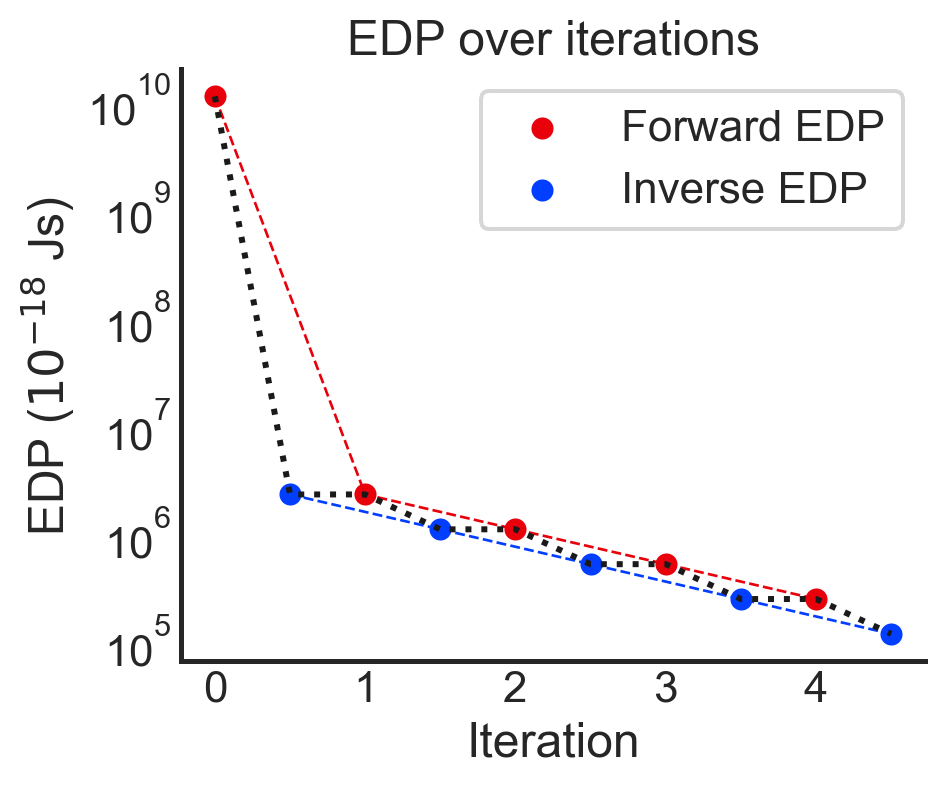

In [183]:
plt.title("EDP over iterations")
c = sns.scatterplot(x=range(num_iters), y=forward_edp, label="Forward EDP", c="r")
sns.lineplot(x=range(num_iters), y=forward_edp, linestyle="dashed", linewidth=1, c="r")
c = sns.scatterplot(
    x=np.arange(0.5, num_iters + 0.5), y=inverse_edp, label="Inverse EDP", c="b"
)
sns.lineplot(
    x=np.arange(0.5, num_iters + 0.5),
    y=inverse_edp,
    linestyle="dashed",
    linewidth=1,
    c="b",
)
sns.lineplot(x=np.arange(0, num_iters, 0.5), y=edps, linestyle="dotted", c="k")

sns.despine()

plt.xticks(range(num_iters))
plt.xlabel("Iteration")
plt.ylabel(r"EDP ($10^{-18}$ Js)")
plt.legend()
plt.yscale("log")
plt.savefig(f"{log_dir}/edp_over_iterations.png")
plt.show()

In [184]:
rcs = []
for i in range(num_iters):
    rcs.append(yaml.load(open(f"{log_dir}/rcs_{i}.yaml", "r"), Loader=yaml.Loader))

In [185]:
print(rcs)

[{'Cacti': {'C_fringe': 4.4609726306906483e-17, 'C_g_ideal': 3.702607283668293e-16, 'C_junc': 5.576215788287371e-16, 'C_junc_sw': 1.3940539470749116e-16, 'C_ox': 9.981426260613896e-15, 'I_g_on_n': 1e-09, 'I_off_n': 1e-09, 'I_on_n': 0.0006005026780564604, 'I_on_p': 0.0007126, 'Mobility_n': 19079579940.400284, 'Vdd': 0.6691458947426818, 'Vdsat': 0.07137556208707142, 'Vth': 0.13219534768731964, 'Wmemcella': 0.7304842682414188, 'Wmemcellnmos': 1.159852883680188, 'Wmemcellpmos': 1.23, 'alpha_scatter': 1.0, 'area_cell': 81.41275050622855, 'asp_ratio_cell': 0.8141275050480381, 'aspect_ratio': 1.3382917891381363, 'barrier_thickness': 0.01, 'chip_layout_overhead': 1.2, 'core_tx_density': 0.6125, 'dishing_thickness': 1e-09, 'dram_cell_C': 1e-09, 'dram_cell_I_off_worst_case_len_temp': 1e-09, 'dram_cell_I_on': 1e-09, 'dram_cell_Vdd': 1e-09, 'fringe_cap': 6.412648156316742e-17, 'gmp_to_gmn_multiplier': 0.6802983261424085, 'horiz_dielectric_constant': 1.5105968569896713, 'ild_thickness': 0.267658357

In [186]:
# remove all parameters in rcs that didn't change
keys = list(rcs[0]["Ceff"].keys())

for k in keys:
    val = rcs[0]["Ceff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Ceff"][k]
        to_pop &= v == val
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Ceff"].pop(k)

    val = rcs[0]["Reff"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Reff"][k]
        to_pop &= v == val
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Reff"].pop(k)
print(rcs)

# remove all cacti parameters that didn't change
cacti_keys = list(rcs[0]["Cacti"].keys())

for k in cacti_keys:
    val = rcs[0]["Cacti"][k]
    to_pop = True
    for i in range(1, num_iters):
        v = rcs[i]["Cacti"][k]
        to_pop &= v == val
        val = v
    if to_pop:
        for i in range(num_iters):
            rcs[i]["Cacti"].pop(k)

[{'Cacti': {'C_fringe': 4.4609726306906483e-17, 'C_g_ideal': 3.702607283668293e-16, 'C_junc': 5.576215788287371e-16, 'C_junc_sw': 1.3940539470749116e-16, 'C_ox': 9.981426260613896e-15, 'I_g_on_n': 1e-09, 'I_off_n': 1e-09, 'I_on_n': 0.0006005026780564604, 'I_on_p': 0.0007126, 'Mobility_n': 19079579940.400284, 'Vdd': 0.6691458947426818, 'Vdsat': 0.07137556208707142, 'Vth': 0.13219534768731964, 'Wmemcella': 0.7304842682414188, 'Wmemcellnmos': 1.159852883680188, 'Wmemcellpmos': 1.23, 'alpha_scatter': 1.0, 'area_cell': 81.41275050622855, 'asp_ratio_cell': 0.8141275050480381, 'aspect_ratio': 1.3382917891381363, 'barrier_thickness': 0.01, 'chip_layout_overhead': 1.2, 'core_tx_density': 0.6125, 'dishing_thickness': 1e-09, 'dram_cell_C': 1e-09, 'dram_cell_I_off_worst_case_len_temp': 1e-09, 'dram_cell_I_on': 1e-09, 'dram_cell_Vdd': 1e-09, 'fringe_cap': 6.412648156316742e-17, 'gmp_to_gmn_multiplier': 0.6802983261424085, 'horiz_dielectric_constant': 1.5105968569896713, 'ild_thickness': 0.267658357

In [187]:
print(f"cacti keys:")
[print(k) for k in rcs[0]["Cacti"].keys()]

cacti keys:
C_fringe
C_g_ideal
C_junc
C_junc_sw
C_ox
I_on_n
Mobility_n
Vdd
Vdsat
Vth
Wmemcella
Wmemcellnmos
area_cell
asp_ratio_cell
aspect_ratio
fringe_cap
gmp_to_gmn_multiplier
horiz_dielectric_constant
ild_thickness
l_elec
miller_value
n2p_drv_rt
nmos_effective_resistance_multiplier
vert_dielectric_constant
wire_pitch


[None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None,
 None]

In [188]:
rc_df = pd.DataFrame(rcs)
print(rc_df.columns)

Index(['Cacti', 'Ceff', 'Reff', 'other'], dtype='object')


In [189]:
def plot_from_rcs(k1, k2s, num_iters, rcs, title="", ylabel="", labels=[]):
    if type(k2s) is not list:
        k2s = [k2s]
    for i in range(len(k2s)):
        k2 = k2s[i]

        val = np.asarray(list(map(lambda x: float(x[k1][k2]), rcs)))
        # name = f"{k1}_{k2}" if k1 != "other" else k2
        val = val / val[0]
        if len(labels) != 0:
            lbl = labels[i]
        else:
            lbl = k2
        c = sns.scatterplot(x=range(num_iters), y=val, label=lbl)
        sns.lineplot(
            x=range(num_iters), y=val, linestyle="dotted", markers=True
        )  # c= c.get_facecolor())
    if title == "":
        title = f"{k1} over iterations"
    else:
        title += " over iterations"
    plt.title(title)
    sns.despine()

    # for i in range(num_iters):
    #     plt.scatter(rcs[i][k1], rcs[i][k2], label=f"iter {i}")
    plt.xlabel("Iteration")
    if ylabel == "":
        ylabel = f"{k1} (normalized)"
    else:
        ylabel += " (normalized)"
    plt.ylabel(ylabel)
    plt.legend()
    plt.savefig(f"{log_dir}/{'_'.join(title.split(' '))}.png")
    plt.show()

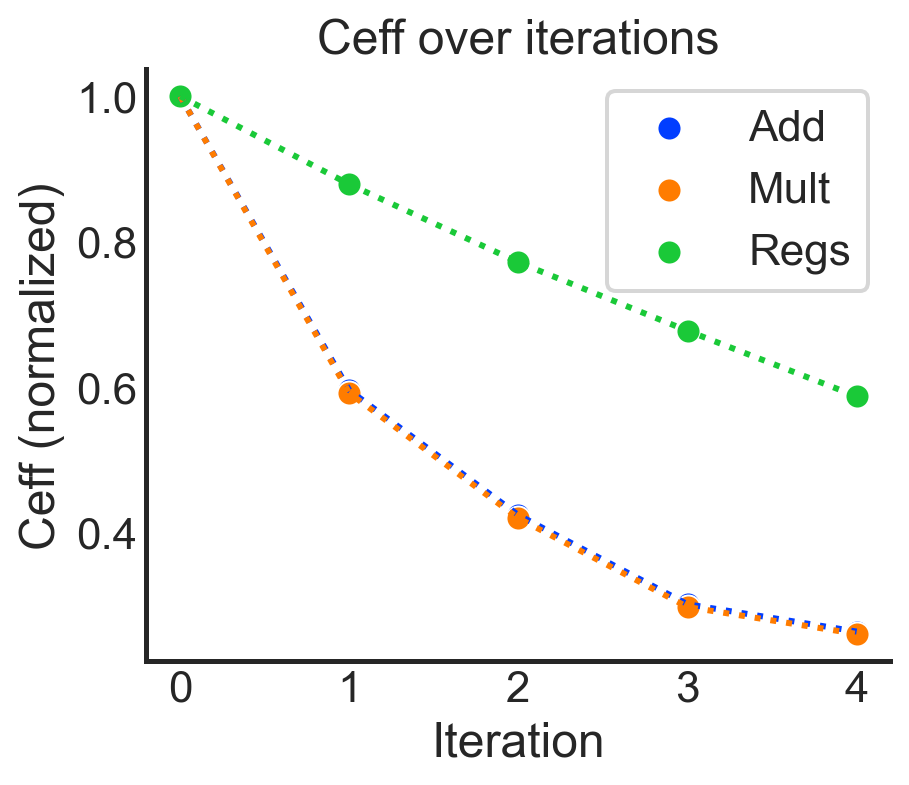

In [190]:
k1 = "Ceff"
k2s = list(rcs[0][k1].keys())

plot_from_rcs(k1, k2s, num_iters, rcs)

/var/folders/pb/xkf_1m6d4_b_x6511mct3t3r0000gn/T/ipykernel_98177/25122611.py:7: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context("mode.use_inf_as_na", True):


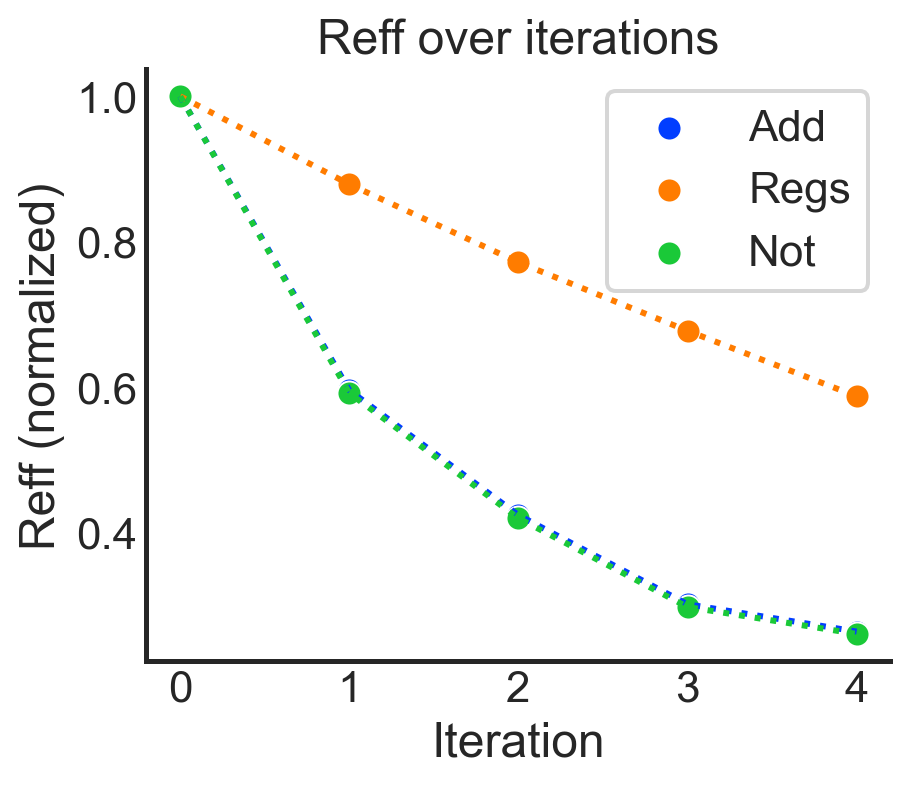

In [191]:
k1 = "Reff"
k2s = list(rcs[0][k1].keys())
tmp_idx = k2s.index("Not")
k2s.pop(tmp_idx)
k2s.append("Not")

with pd.option_context("mode.use_inf_as_na", True):
    plot_from_rcs(k1, k2s, num_iters, rcs)

In [192]:
k1 = "other"
k2s = ["MemReadL", "MemWriteL", "BufL", "OffChipIOL"]
labels = ["Mem Read", "Mem Write", "Buf", "Off-Chip IO"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Latency", "Latency", labels)

KeyError: 'MemReadL'

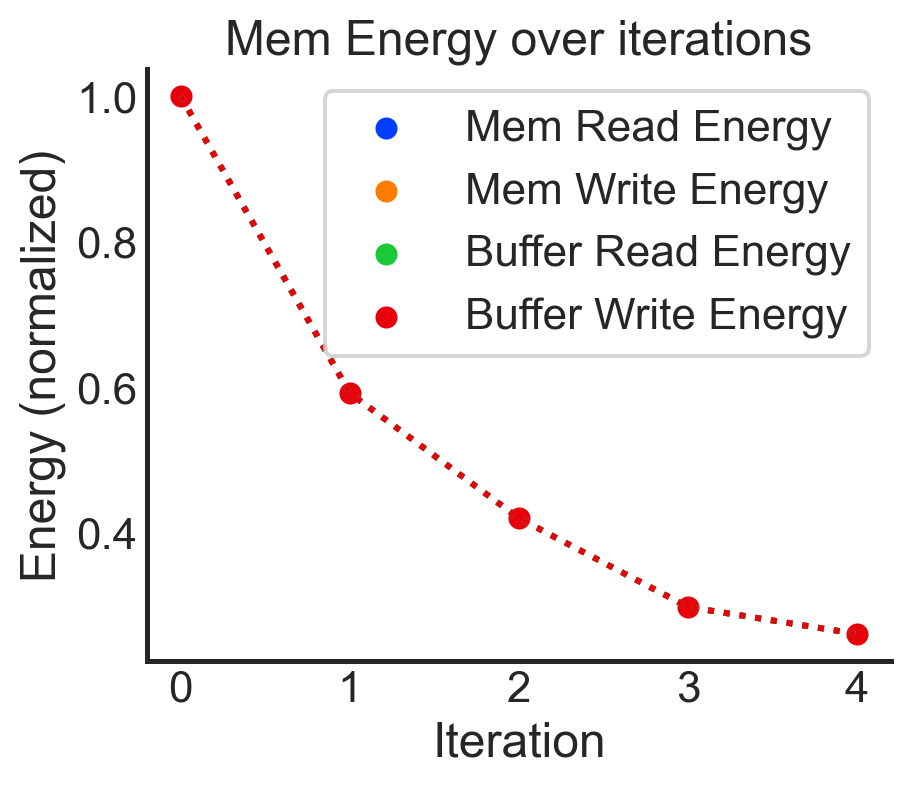

In [193]:
k1 = "other"
k2s = ["MemReadEact", "MemWriteEact", "BufReadEact", "BufWriteEact"]  # "MemPpass"]
labels = [
    "Mem Read Energy",
    "Mem Write Energy",
    "Buffer Read Energy",
    "Buffer Write Energy",
]  # "Passive"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Energy", "Energy", labels)

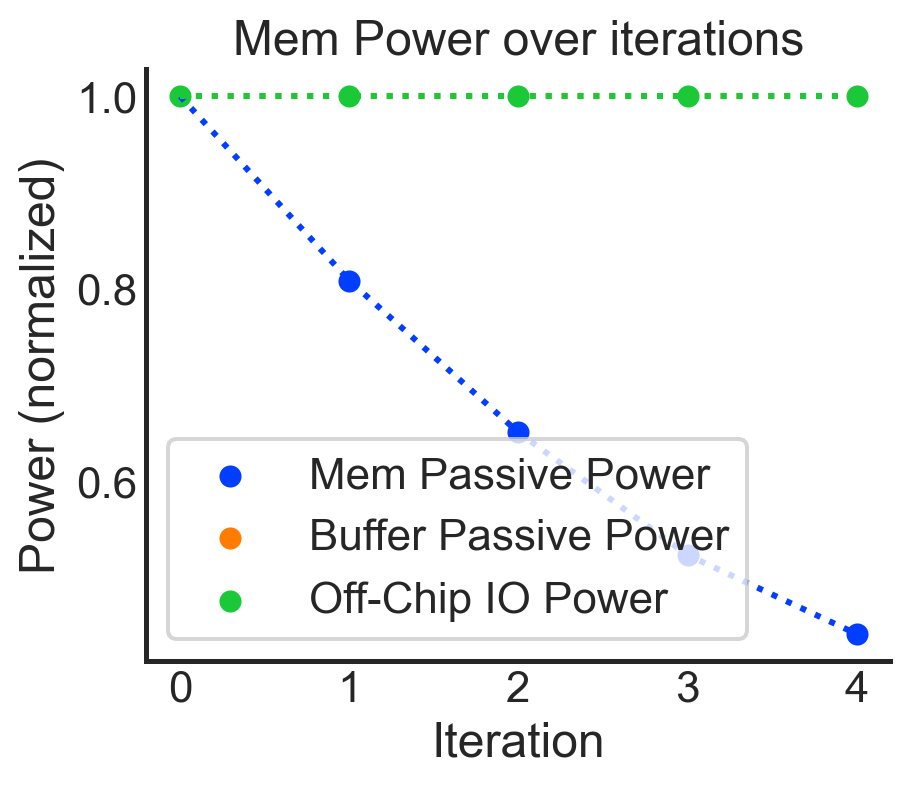

In [194]:
k1 = "other"
k2s = ["MemPpass", "BufPpass", "OffChipIOPact"]
labels = ["Mem Passive Power", "Buffer Passive Power", "Off-Chip IO Power"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Mem Power", "Power", labels)

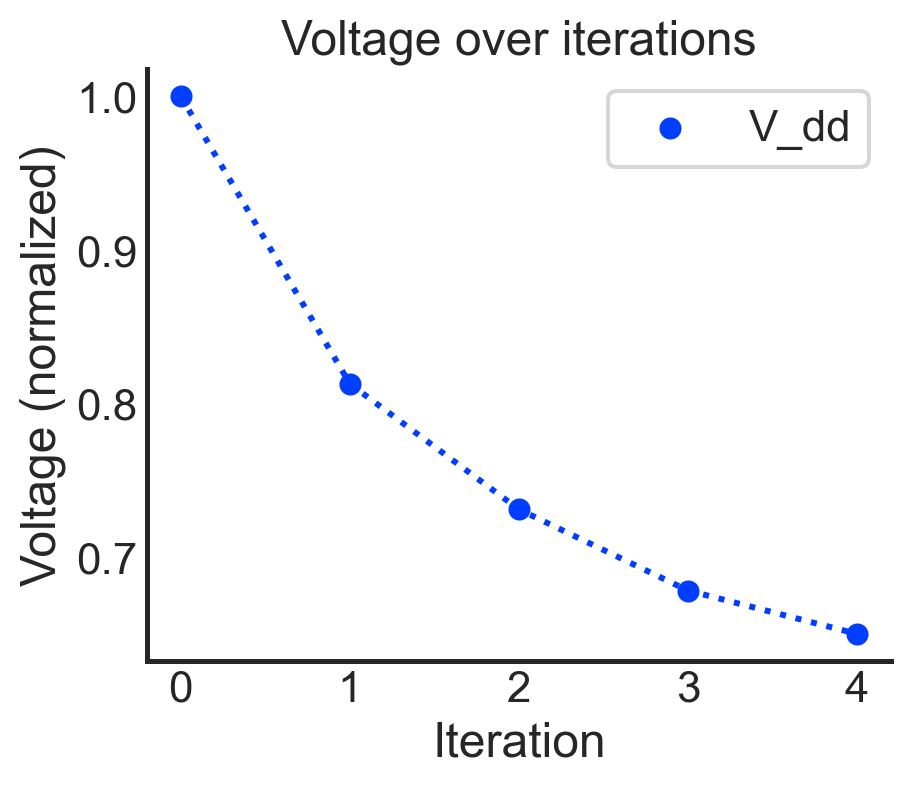

In [195]:
k1 = "other"
k2s = ["V_dd"]

plot_from_rcs(k1, k2s, num_iters, rcs, "Voltage", "Voltage")

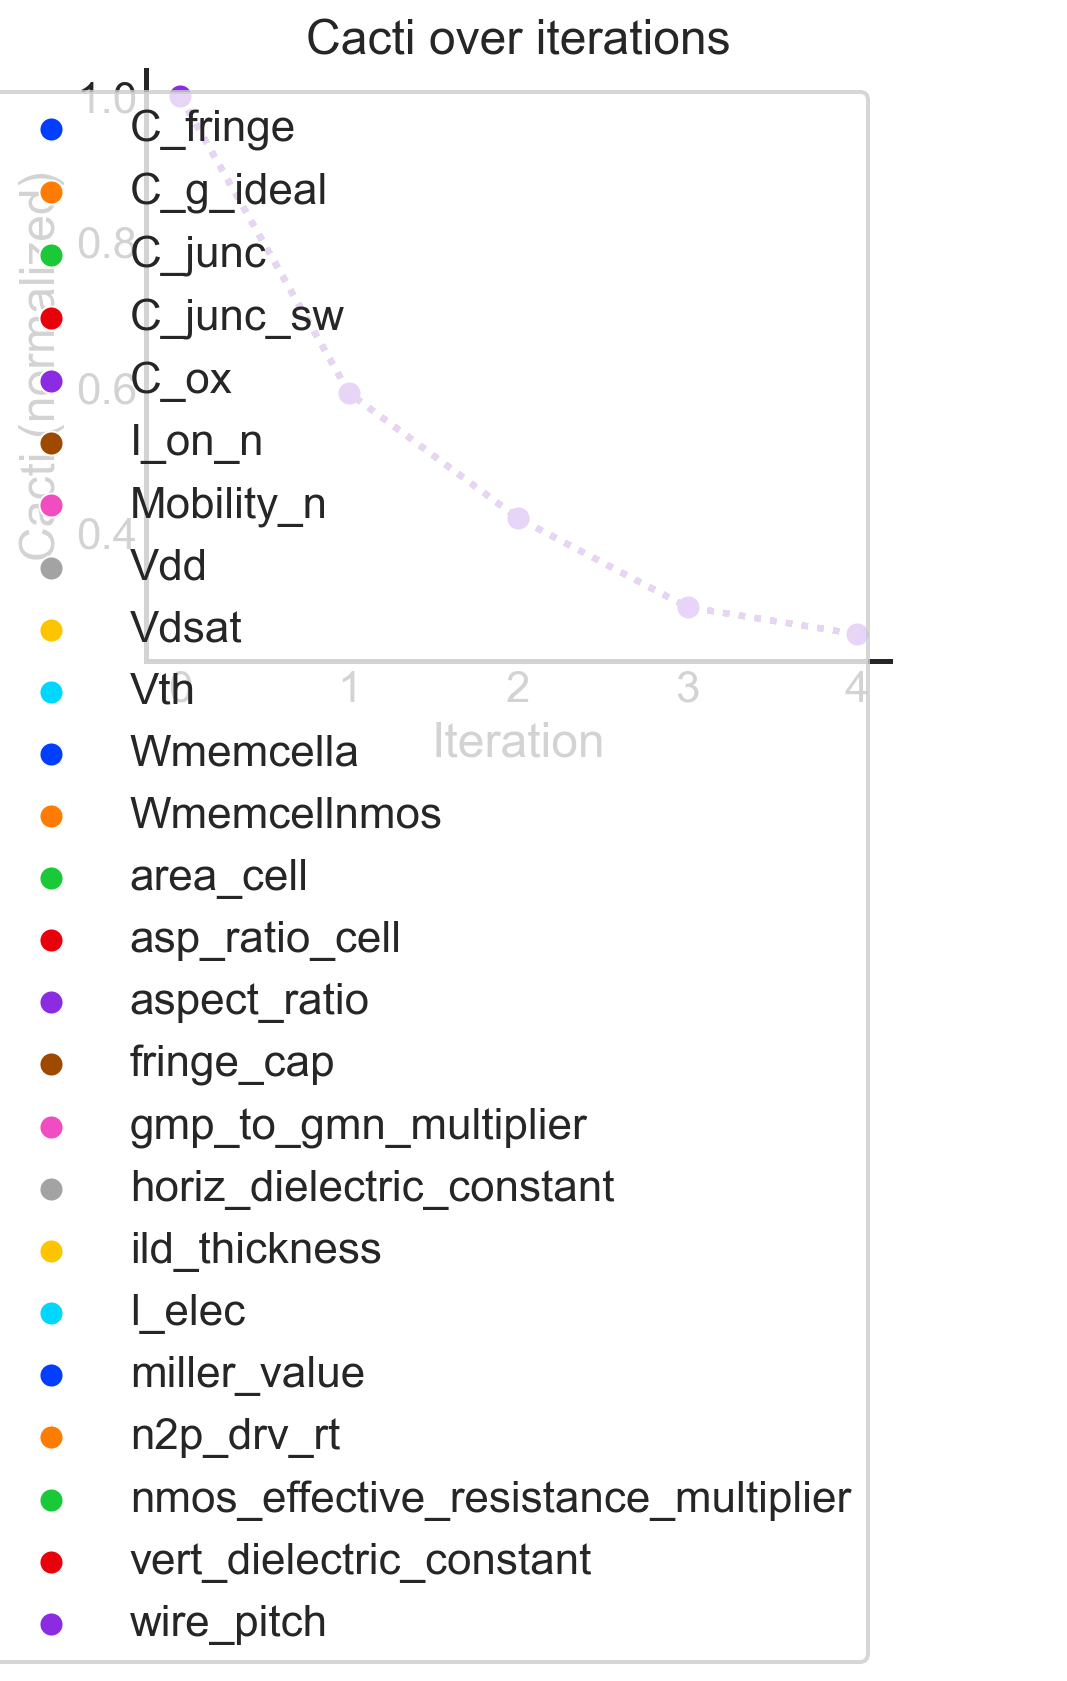

In [196]:
k1 = "Cacti"
k2s = list(rcs[0][k1].keys())

plot_from_rcs(k1, k2s, num_iters, rcs)#, "Capacitance", "Capacitance")

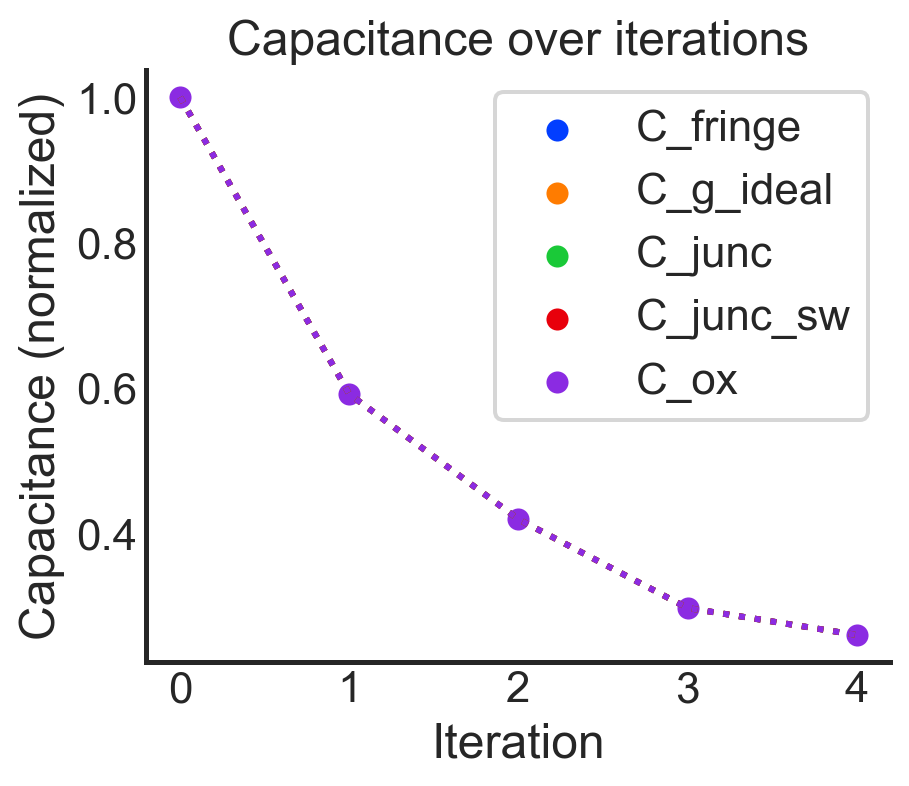

In [197]:
k1 = "Cacti"
k2s = [k for k in list(rcs[0][k1].keys()) if "C_" in k]

plot_from_rcs(k1, k2s, num_iters, rcs, "Capacitance", "Capacitance")

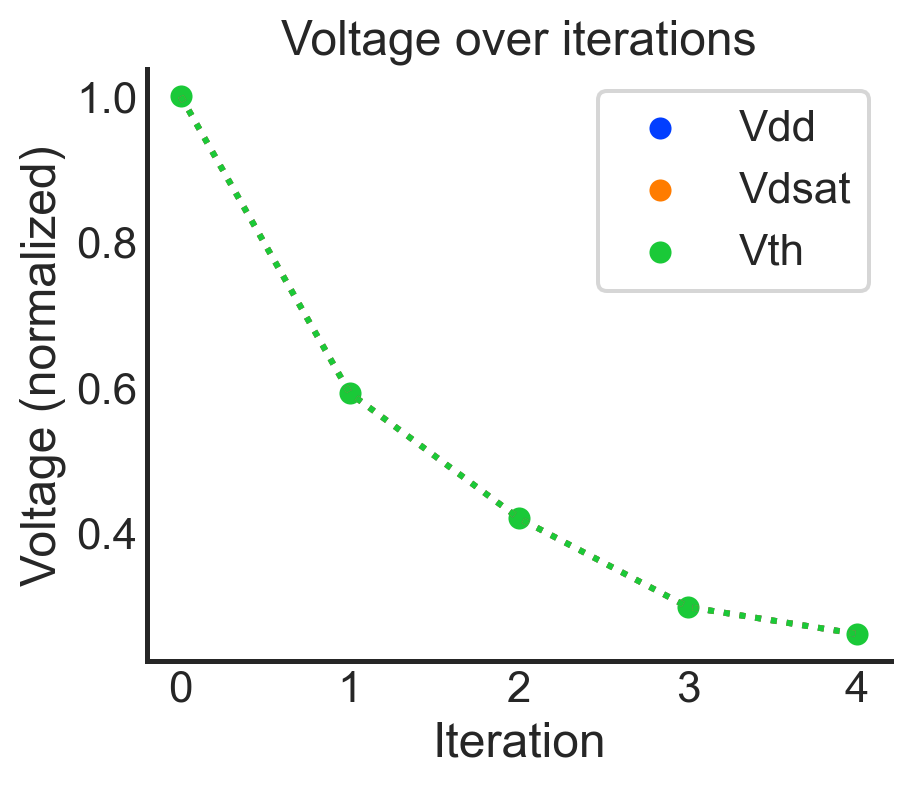

In [198]:
k1 = "Cacti"
k2s = [k for k in list(rcs[0][k1].keys()) if "V" in k]

plot_from_rcs(k1, k2s, num_iters, rcs, "Voltage", "Voltage")

val_0s: [4.4609726306906483e-17, 3.702607283668293e-16, 5.576215788287371e-16, 1.3940539470749116e-16, 9.981426260613896e-15, 0.0006005026780564604, 19079579940.400284, 0.6691458947426818, 0.07137556208707142, 0.13219534768731964, 0.7304842682414188, 1.159852883680188, 81.41275050622855, 0.8141275050480381, 1.3382917891381363, 6.412648156316742e-17, 0.6802983261424085, 1.5105968569896713, 0.26765835782619346, 0.014832733996220215, 0.8364323682113353, 1.3661728680812044, 0.8587372315873611, 2.1747241573431935, 1.3940539470148674]
val_1s: [2.6383769223668787e-17, 2.1898528457299316e-16, 3.297971152894873e-16, 8.244927882262597e-17, 5.9033683633103576e-15, 0.0003551585132951133, 11284338096.035042, 0.39575653847543635, 0.042214030754398085, 0.07818500211672613, 0.43203422100655803, 0.6859779995491154, 48.15037882977319, 0.4815037882867728, 0.7915130766487913, 3.7926668256389927e-17, 0.4023524806278709, 0.893420385267323, 0.15830261532871745, 0.008772603266149299, 0.49469567290549465, 0.80

(array([ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 25.,  0.,  0.,
         0.,  0.,  0.,  0.,  0.,  0.,  0.]),
 array([0.09143535, 0.14143535, 0.19143535, 0.24143535, 0.29143535,
        0.34143535, 0.39143535, 0.44143535, 0.49143535, 0.54143535,
        0.59143535, 0.64143535, 0.69143535, 0.74143535, 0.79143535,
        0.84143535, 0.89143535, 0.94143535, 0.99143535, 1.04143535,
        1.09143535]),
 <BarContainer object of 20 artists>)

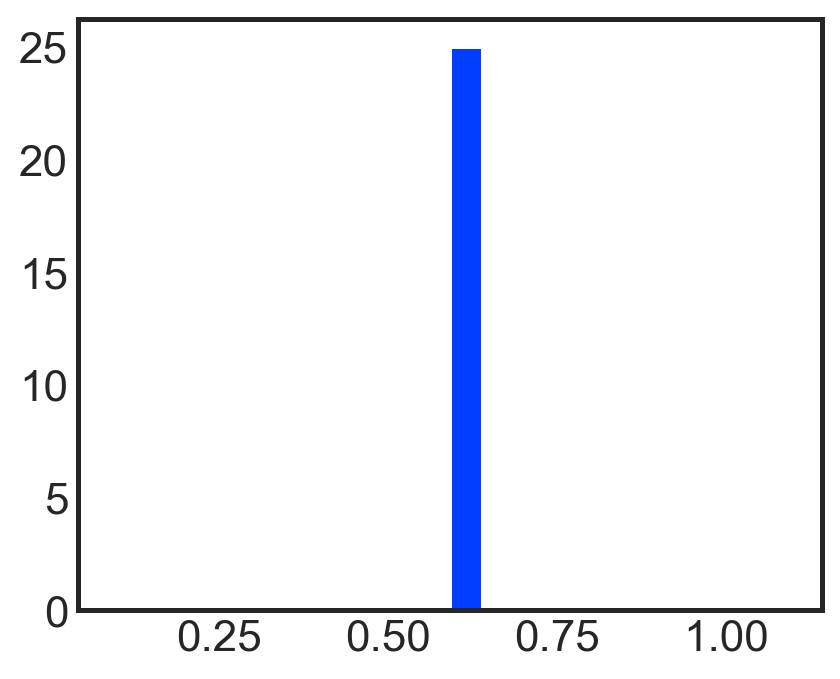

In [199]:
k1 = "Cacti"
val_0s = list(rcs[0][k1].values())
print(f"val_0s: {val_0s}")
val_1s = list(rcs[1][k1].values())
print(f"val_1s: {val_1s}")
vals = [val_1s[0] / val_0s[0] for i in range(len(val_0s))]
print(f"vals: {vals}")
plt.hist(vals, bins=20)

#### Area

#### Get stalled node statistics

In [18]:
# Specify the directory path and the file format
file_format = 'schedule_*.gml'  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + '/' + file_format))
schedule_node_counts = pd.DataFrame()
print(files)
# Print the list of files
for file in files:
    g = nx.read_gml(file)
    func_counts = hardwareModel.get_func_count(g)
    stall_nodes = hardwareModel.get_nodes_with_func(g, "stall")
    stall_funcs, counts = np.unique(list(map(lambda x: "stall_" + x.split("_")[3], stall_nodes.keys())), return_counts = True)
    assert func_counts["stall"] == counts.sum()
    stall_counts = dict(zip(stall_funcs, counts))
    dict_counts = {**func_counts, **stall_counts}
    schedule_node_counts = pd.concat(
        [schedule_node_counts, pd.DataFrame([dict_counts])], ignore_index=True
    )

print(schedule_node_counts)

['codesign_log_dir/2024-06-25_15-03-45/schedule_0.gml', 'codesign_log_dir/2024-06-25_15-03-45/schedule_1.gml', 'codesign_log_dir/2024-06-25_15-03-45/schedule_2.gml', 'codesign_log_dir/2024-06-25_15-03-45/schedule_3.gml', 'codesign_log_dir/2024-06-25_15-03-45/schedule_4.gml']
   Regs  MainMem  end  Mult  stall  Buf  Add  stall_Add  stall_Buf  stall_Regs
0    36       36    1     8    378   36   12         20        312          46
1    36       36    1     8    378   36   12         20        312          46
2    36       36    1     8    378   36   12         20        312          46
3    36       36    1     8    378   36   12         20        312          46
4    36       36    1     8    378   36   12         20        312          46


['stall_Add', 'stall_Buf', 'stall_Regs']


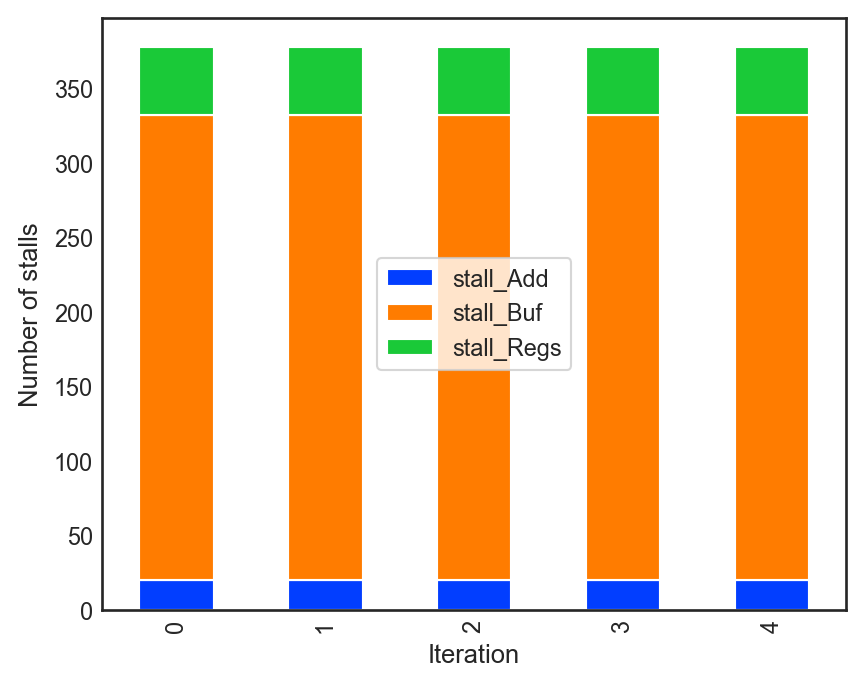

In [19]:
stall_columns = list(filter(lambda x: "stall_" in x, list(schedule_node_counts.columns)))
print(stall_columns)
schedule_node_counts[stall_columns].plot(kind="bar", stacked=True)
plt.xlabel("Iteration")
plt.ylabel("Number of stalls")
plt.savefig(f"{log_dir}/stalls_over_iterations.png")

#### Architecture Change Statistics

In [20]:
file_format = "netlist_*.gml"  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + "/" + file_format))
netlist_function_counts = pd.DataFrame()

# Print the list of files
for file in files:
    g = nx.read_gml(file)
    func_counts = hardwareModel.get_func_count(g)
    netlist_function_counts = pd.concat(
        [netlist_function_counts, pd.DataFrame([func_counts])], ignore_index=True
    )

print(netlist_function_counts)

   Regs  MainMem  Mult  Buf  Add
0     2        1     1    1    1
1     2        1     1    1    1
2     2        1     1    1    1
3     2        1     1    1    1
4     2        1     1    1    1


#### Tech params

In [155]:
file_format = "tech_params*.yaml"  # Replace with your desired file format

# Get a list of files with the specified format in the directory
files = sorted(glob.glob(log_dir + "/" + file_format))
tech_params_df = pd.DataFrame()


def convert_tech_params_to_df(tech_params: dict, t: int) -> pd.DataFrame:
    """
    Returns a DF with index operator and iteration step.
    """
   
    area= []
    dynamic_power= []
    leakage_power= []
    dynamic_energy= []
    latency=[]
    operator= []
    T= []
     
    for key in tech_params["area"].keys():
        area.append(tech_params["area"][key])
        dynamic_power.append(tech_params["dynamic_power"][key] if key in tech_params["dynamic_power"] else np.nan)
        leakage_power.append(tech_params["leakage_power"][key] if key in tech_params["leakage_power"] else np.nan)
        dynamic_energy.append(tech_params["dynamic_energy"][key] if key in tech_params["dynamic_energy"] else np.nan)
        latency.append(tech_params["latency"][key] if key in tech_params["latency"] else np.nan)
        operator.append(key)
        T.append(t)
      

    for key in tech_params["dynamic_energy"].keys():
        for k2 in tech_params["dynamic_energy"][key].keys():
            area.append(np.nan)
            dynamic_power.append(np.nan)
            leakage_power.append(np.nan)
            dynamic_energy.append(tech_params["dynamic_energy"][key][k2] if k2 in tech_params["dynamic_energy"][key] else np.nan)
            latency.append(np.nan)
            operator.append(key + "_" + k2)
            T.append(t)

    ind = pd.MultiIndex.from_arrays([T, operator], names=("T", "Operator"))
    df = pd.DataFrame(
        {
            "Area": area,
            "Dynamic Power": dynamic_power,
            "Leakage Power": leakage_power,
            "Dynamic Energy": dynamic_energy,
            "Latency": latency,
        },
        index=ind,
    )                   
    return df


# Print the list of files
for t, file in enumerate(files):
    tp = yaml.load(open(file, "r"), Loader=yaml.Loader)
    tp_df = convert_tech_params_to_df(tp, t)
    tech_params_df = pd.concat([tech_params_df, tp_df])


print(tech_params_df)

                        Area  Dynamic Power  Leakage Power Dynamic Energy  \
T Operator                                                                  
0 Add            379348800.0  273029.471834    3325.527614            NaN   
  And             50369960.0    9599.291155     622.308549            NaN   
  BitAnd          50369960.0    9599.291155     622.308549            NaN   
  BitOr           50369960.0    9599.291155     622.308549            NaN   
  BitXor          50369960.0    9599.291155     622.308549            NaN   
...                      ...            ...            ...            ...   
9 USub           379348800.0   58782.433388    8489.657914            NaN   
  Buf_Read               NaN            NaN            NaN       0.001715   
  Buf_Write              NaN            NaN            NaN       0.002113   
  MainMem_Read           NaN            NaN            NaN       0.049079   
  MainMem_Write          NaN            NaN            NaN        0.05165   

lt operators: ['Buf', 'FloorDiv', 'LShift', 'Lt', 'MainMem', 'Mult', 'NotEq', 'RShift', 'Sub']
gt operators: ['And', 'Eq', 'Gt', 'Invert', 'Mod', 'Not', 'Regs']
eq operators: ['BitAnd', 'BitOr', 'BitXor', 'GtE', 'IsNot', 'LtE', 'UAdd', 'USub']


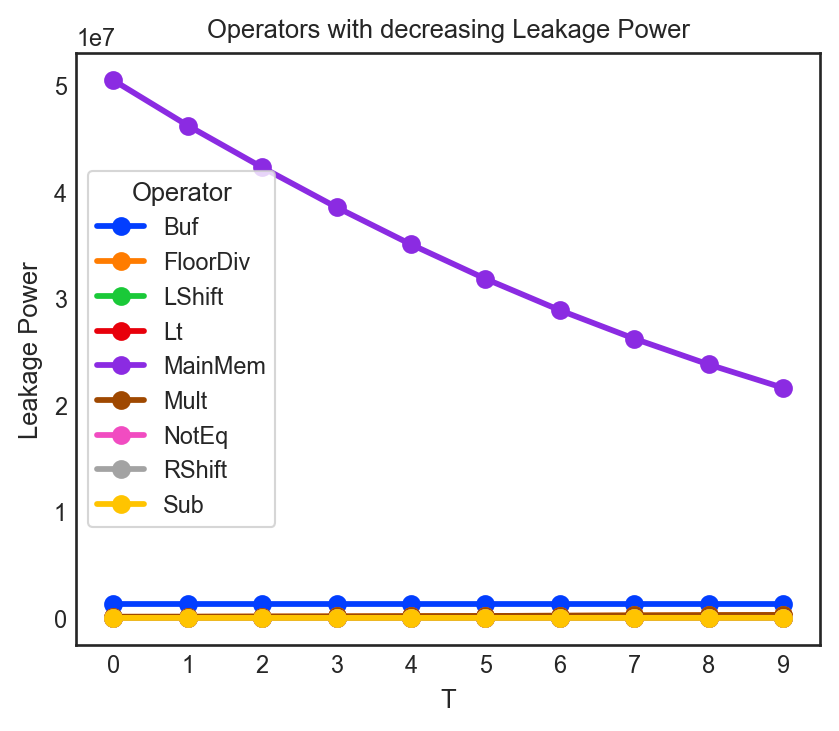

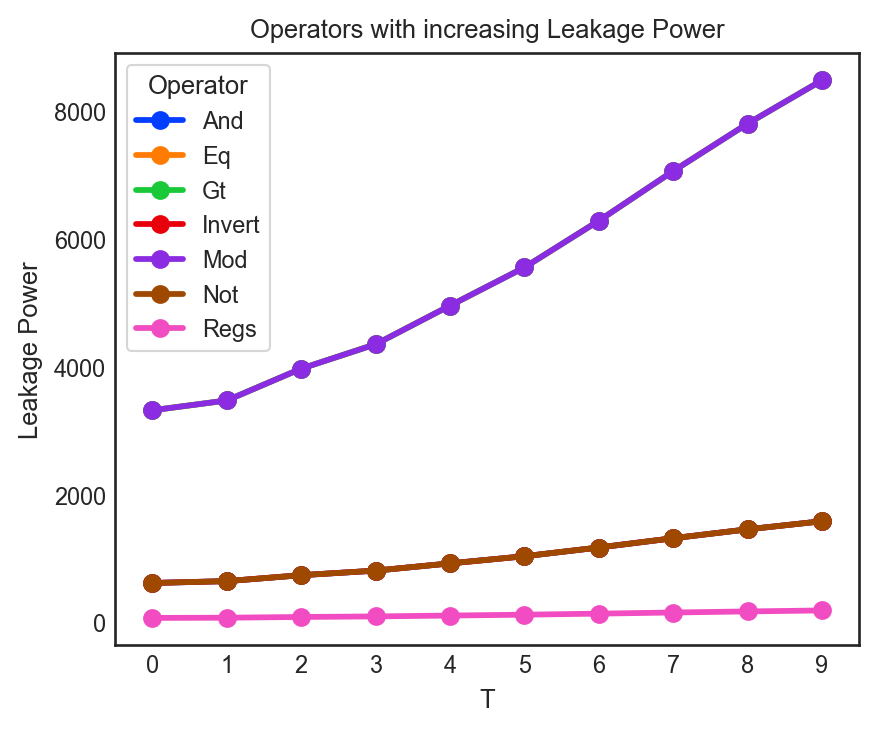

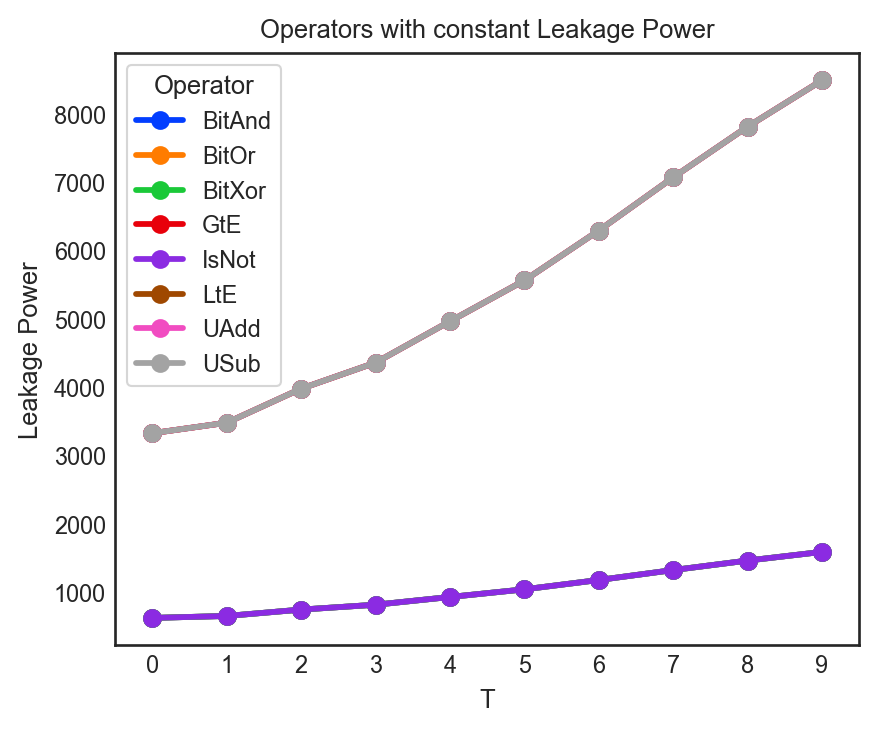

In [156]:
lt_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] > tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"lt operators: {lt_operators}")
gt_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] < tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"gt operators: {gt_operators}")
eq_operators = (
    tech_params_df[
        (tech_params_df.index.get_level_values("T") == t)
        & (tech_params_df["Leakage Power"] == tech_params_df["Leakage Power"].shift(1))
    ]
    .index.get_level_values("Operator")
    .tolist()
)
print(f"eq operators: {eq_operators}")

# operators = ['OffChipIO', "MainMem", "Buf", "Regs"]
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(lt_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with decreasing Leakage Power")
plt.show()
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(gt_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with increasing Leakage Power")
plt.show()
sns.pointplot(
    data=tech_params_df[
        tech_params_df.index.get_level_values("Operator").isin(eq_operators)
    ],
    x="T",
    y="Leakage Power",
    hue="Operator",
)
plt.title("Operators with constant Leakage Power")
plt.show()

In [157]:
tech_params_df[tech_params_df.index.get_level_values("Operator") == "FloorDiv"]["Latency"]

T  Operator
0  FloorDiv    0.49
1  FloorDiv    0.49
2  FloorDiv    0.49
3  FloorDiv    0.49
4  FloorDiv    0.49
5  FloorDiv    0.49
6  FloorDiv    0.49
7  FloorDiv    0.49
8  FloorDiv    0.49
9  FloorDiv    0.49
Name: Latency, dtype: float64